In [1]:
################################
#### IMPORTS AND INICIALIZATIONS
################################

import re
import pandas as pd
import numpy as np
from keras.models import Model
from keras.layers import Input, Dense
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

data = 'RAVEN/TrialRightWrong/Trial'

# All the files we need
files = ['/DEI_trial_by_trial_Right.xlsx', 
         '/DEI_trial_by_trial_Wrong.xlsx', 
         '/esec_trial_by_trial_Right.xlsx',
         '/esec_trial_by_trial_Wrong.xlsx']
genreFile = 'RAVEN/Informação_género.txt'



Using TensorFlow backend.


In [2]:
##################
## EXTRACT DATA ##
##################

# Initialize a dict for aggregate the values for training and testing
values = { 'TRAINING': {}, 'TESTING': {} }
for file in files:
    
    # For each file
    f = pd.ExcelFile(data+file)

    # For each Train
    for sheet in f.sheet_names:
        
        df = pd.read_excel(f,  sheet_name=sheet)
        # Get the fatigue value for each person
        # In the 'unnamed:22' column is where person id is
        # Notice that if a person isn't in the 'right files', so he is in the 'wrong files' 
        category = 'TRAINING' if 'TRAINING' in sheet else 'TESTING' if 'TESTING' in sheet else None  
        if category and df.shape[0] > 0:
            dataValues = values[category]

            for index, row in df[df.columns].iterrows():
                *rest,id = row 
                cell = rest
                cell += [1 if (file=='/DEI_trial_by_trial_Right.xlsx' or file=='/esec_trial_by_trial_Right.xlsx') else 0]
                cell += [int("DEI" in id)] 
                if (id not in dataValues):
                    dataValues[id] = [cell]
                else:
                    dataValues[id] += [cell] 
    
        
#Extract the genre from genreFile
with open(genreFile, "r") as f:
    for l in f:
        l = l.strip()
        if l=="" or '--' in l:continue
        id, genre, rest = l.split(' - ')
        
        if id[-2] == '_': id = id[:-1] + '0' + id[-1]
        for dataDict in [values['TRAINING'], values['TESTING']]: #get dicts train and test
            for i in range(len(dataDict[id])):
                dataDict[id][i].append(int(genre=='Masculino')) 
# For each person ( PERSON : list([-...characteristic_values, course genre ]))
                

In [3]:
#################
## PRE PROCESS ##
#################

# For each person ( PERSON : list([genre, course, fatigue_value, correct/incorrect ]))        
items = { 'TRAINING': [], 'TESTING': [] }
for dataType in ['TRAINING','TESTING']:
    for v in values[dataType].values():
        items[dataType] += v
items['TRAINING'] = np.matrix(items['TRAINING'])
items['TESTING'] = np.matrix(items['TESTING'])

Itrain = items['TRAINING']   #introducing missing values by the average
col_mean = np.nanmean(Itrain, axis=0)
inds = np.where(np.isnan(Itrain))
Itrain[inds] = np.take(col_mean, inds[1])

scaler = MinMaxScaler()
scaler.fit(Itrain[:,:-2])

Itest = items['TESTING']   #fixing missing values by the average
col_mean = np.nanmean(Itest, axis=0)
inds = np.where(np.isnan(Itest))
Itest[inds] = np.take(col_mean, inds[1])

data_trainX = scaler.transform(Itrain[:,:-2]) #normalize data
data_trainY = Itrain[:,-2:]

data_testX = scaler.transform(Itest[:,:-2]) #normalize data
data_testY = Itest[:,-2:] 


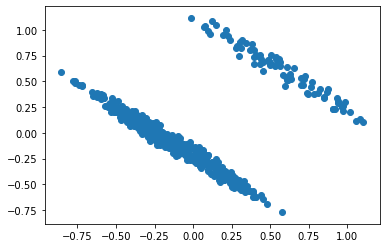

In [4]:
#######
# PCA #
#######

pca = PCA(n_components=2)
pcaData = pca.fit_transform(data_trainX)

plt.scatter(pcaData[:,-2], pcaData[:,-1])

plt.show()

In [5]:
####################
## NEURAL NETWORK ##
####################

np.random.seed(2)
inputs = Input(shape=(data_trainX.shape[1],))
x = Dense(32, activation='relu')(inputs)
x = Dense(8, activation='relu')(x)
x = Dense(8, activation='relu')(x)
outputs = Dense(data_trainY.shape[1], activation='sigmoid')(x)
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

model.fit(data_trainX, data_trainY, epochs=25, batch_size=16, verbose=0)
predicts = (model.predict(data_testX)>0.5)








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where










# Metrics

In [6]:
print('accuracy:',(predicts==data_testY).sum()/(predicts.shape[0]*predicts.shape[1]))
print('-----')
genrePredicts = predicts[:,-1:]
genreTest = data_testY[:,-1:]
indnames = ['FEMALE','MALE']
print(f"genre accuracy: {(genrePredicts==genreTest).sum()/genrePredicts.shape[0]:.3f}")
for i in range(2):
    sum_predicts = (genrePredicts==i).sum()
    sum_true = (genreTest==i).sum()
    precision = np.multiply(genrePredicts==i,genreTest==i).sum()/sum_predicts if sum_predicts else 0
    recall = np.multiply(genrePredicts==i,genreTest==i).sum()/sum_true
    f1scor = 2*precision*recall/(precision+recall) if precision+recall else 0.0
    print('---')
    print(f"precision genre {indnames[i]}: {precision:.3f}")    
    print(f"reccal genre {indnames[i]}: {recall:.3f}")
    print(f"f1-scor genre {indnames[i]}: {f1scor:.3f}")

print('-----')
coursePredicts = predicts[:,-2:-1] #same as [:,-2] but in matrix form
courseTest = data_testY[:,-2:-1] #same as [:,-2] but in matrix form
indnames = ['ESEC','DEI']
print(f"course accuracy: {(coursePredicts==courseTest).sum()/coursePredicts.shape[0]:.3f}")
for i in range(2):
    sum_predicts = (coursePredicts==i).sum()
    sum_true = (courseTest==i).sum()
    precision = np.multiply(coursePredicts==i,courseTest==i).sum()/sum_predicts if sum_predicts else 0
    recall = np.multiply(coursePredicts==i,courseTest==i).sum()/sum_true
    f1scor = 2*precision*recall/(precision+recall) if precision+recall else 0.0
    print('---')
    print(f"precision genre {indnames[i]}: {precision:.3f}")    
    print(f"reccal genre {indnames[i]}: {recall:.3f}")
    print(f"f1-scor genre {indnames[i]}: {f1scor:.3f}")
print('-----')

groupPredicts = predicts[:,-1:]+predicts[:,-2:-1]*2 #0,1,2,3
groupTest = data_testY[:,-1:]+data_testY[:,-2:-1]*2 #0,1,2,3
print(f"group accuracy: {(groupPredicts==groupTest).sum()/groupPredicts.shape[0]:.3f}")

indnames = ['ESEC AND FEMALE','ESEC AND MALE', 'DEI AND FEMALE', 'DEI AND MALE']
for i in range(4):
    sum_predicts = (groupPredicts==i).sum()
    sum_true = (groupTest==i).sum()
    precision = np.multiply(groupPredicts==i,groupTest==i).sum()/sum_predicts if sum_predicts else 0
    recall = np.multiply(groupPredicts==i,groupTest==i).sum()/sum_true
    f1scor = 2*precision*recall/(precision+recall) if precision+recall else 0.0
    print('---')
    print(f"precision group {indnames[i]}: {precision:.3f}")    
    print(f"reccal group {indnames[i]}: {recall:.3f}")
    print(f"f1-scor group {indnames[i]}: {f1scor:.3f}")
    


accuracy: 0.5827943078913325
-----
genre accuracy: 0.620
---
precision genre FEMALE: 0.419
reccal genre FEMALE: 0.077
f1-scor genre FEMALE: 0.130
---
precision genre MALE: 0.634
reccal genre MALE: 0.937
f1-scor genre MALE: 0.757
-----
course accuracy: 0.546
---
precision genre ESEC: 0.520
reccal genre ESEC: 0.324
f1-scor genre ESEC: 0.399
---
precision genre DEI: 0.556
reccal genre DEI: 0.740
f1-scor genre DEI: 0.635
-----
group accuracy: 0.356
---
precision group ESEC AND FEMALE: 0.265
reccal group ESEC AND FEMALE: 0.083
f1-scor group ESEC AND FEMALE: 0.127
---
precision group ESEC AND MALE: 0.263
reccal group ESEC AND MALE: 0.230
f1-scor group ESEC AND MALE: 0.245
---
precision group DEI AND FEMALE: 0.000
reccal group DEI AND FEMALE: 0.000
f1-scor group DEI AND FEMALE: 0.000
---
precision group DEI AND MALE: 0.395
reccal group DEI AND MALE: 0.748
f1-scor group DEI AND MALE: 0.517
